# Inpainting

Projet ARF - 2017/2018

In [158]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Préambule : régression linéaire, régression ridge et LASSO

![./images/Q1.1.png](attachment:Q1.1.png)

Protocole expérimental pour comparer les trois algos dans le contexte de la classif plug-in:
 - regression linéaire
 - régression ridge
 - algo LASSO

### Experimentation

Nous allons tester avec le meme jeu d'entrainement et de test les trois algorithmes dans le contexte de la classifications plug-in.
Nous testerons avec différents paramètres pour voir comment évolue les résultats ainsi que le nombre de caractéristiques non nulles.

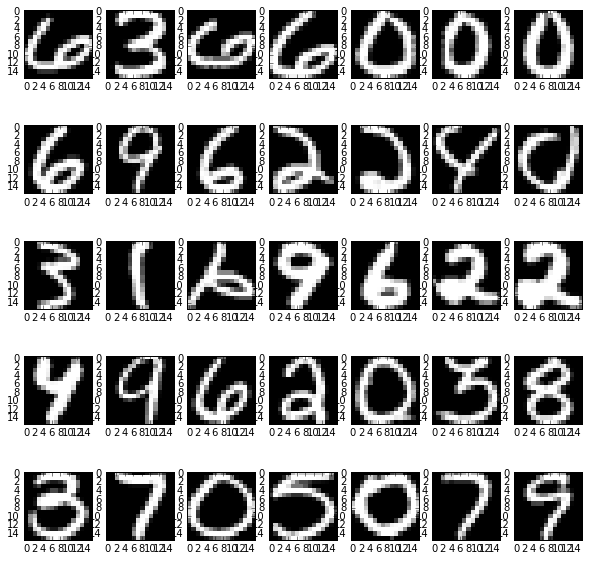

In [72]:
from tools import load_usps, show_sample_usps

training_setx, training_sety = load_usps("USPS_train.txt")
test_setx, test_sety = load_usps("USPS_test.txt")  

show_sample_usps(test_setx)

In [88]:
# We are only checking if they are equal to 6 or not
number = 5

trainy = np.where(training_sety == number, 1, -1)
testy = np.where(test_sety == number, 1, -1)

def plugin(fct, datax, datay):
    return 1 - np.sum(np.sign(fct.predict(datax)) - datay != 0) / datay.size

In [182]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(normalize=True).fit(trainx, trainy)

print("Training set score: {:.2f}".format(lr.score(trainx, trainy)))
print("Test set score: {:.2f}\n".format(lr.score(testx, testy)))

print("Training set score: {:.2f}".format(plugin(lr, trainx, trainy)))
print("Test set score: {:.2f}".format(plugin(lr, testx, testy)))

Training set score: 0.60
Test set score: 0.52

Training set score: 0.98
Test set score: 0.96


In [194]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0, normalize=True).fit(trainx, trainy)

print("Training set score: {:.2f}".format(ridge.score(trainx, trainy)))
print("Test set score: {:.2f}\n".format(ridge.score(testx, testy)))

print("Training set score: {:.2f}".format(plugin(ridge, trainx, trainy)))
print("Test set score: {:.2f}".format(plugin(ridge, testx, testy)))

Training set score: 0.60
Test set score: 0.52

Training set score: 0.98
Test set score: 0.96


In [227]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.00001,normalize=True).fit(trainx, trainy)

print("Training set score: {:.2f}".format(lasso.score(trainx, trainy)))
print("Test set score: {:.2f}\n".format(lasso.score(testx, testy)))

print("Training set score: {:.2f}".format(plugin(lasso, trainx, trainy)))
print("Test set score: {:.2f}".format(plugin(lasso, testx, testy)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.60
Test set score: 0.52

Training set score: 0.98
Test set score: 0.96
Number of features used: 215


In [217]:
def predictFromModel(model, alpha, datax, datay, datatestx, datatesty):
    trainedModel = model(alpha=alpha,normalize=True).fit(datax, datay)
    return [plugin(trainedModel, datax, datay), \
           plugin(trainedModel, datatestx, datatesty), \
           np.sum(trainedModel.coef_ != 0), \
           alpha]

lassoTest = [predictFromModel(Lasso, i, trainx, trainy, testx, testy) for i in np.arange(0.000, 0.003, 0.0001)]
ridgeTest = [predictFromModel(Ridge, i, trainx, trainy, testx, testy) for i in np.arange(0.0, 10, 0.5)]

/home/clement/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/clement/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/clement/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


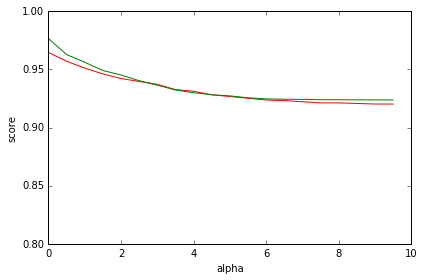

In [215]:
fig, ax1 = plt.subplots()

ax1.plot([i[3] for i in ridgeTest], [i[1] for i in ridgeTest], 'r')
ax1.plot([i[3] for i in ridgeTest], [i[0] for i in ridgeTest], 'g')
ax1.set_ylabel('score')
ax1.set_xlabel('alpha')
ax1.axis((0,10,0.8,1))

fig.tight_layout()
plt.show()

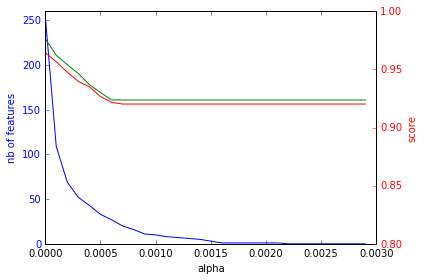

In [216]:

fig, ax1 = plt.subplots()
ax1.plot([i[3] for i in lassoTest], [i[2] for i in lassoTest])
ax1.set_xlabel('alpha')
ax1.set_ylabel('nb of features', color='b')
ax1.axis((0,0.003,0,260))
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot([i[3] for i in lassoTest], [i[1] for i in lassoTest], 'r')
ax2.plot([i[3] for i in lassoTest], [i[0] for i in lassoTest], 'g')
ax2.set_ylabel('score', color='r')
ax2.axis((0,0.003,0.8,1))
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

### Resultats

#### Regression Lineaire



#### Regression Ridge

On peut voir que la régression Ridge donne de moins bons résultats sur l'ensemble d'apprentissage que la régression linéaire mais est meilleur pour généraliser. Ceci est cohérent puisque qu'une régression linéaire tend a sur-apprendre, donnant ainsi de meilleurs performances sur le jeu d'apprentissage mais une moins bonne généralisation.

#### Algorithme du LASSO

La régularisation L1 (utilisé par l'algorithme du LASSO) a pour effet de mettre certain coefficient à zero. Ainsi certaine caractéristique sont totalement ignoré par le modèle. 

On peut le voir comme une sélection automatique des caractéristiques ce qui permet de révéler quelles sont celles qui sont les plus importantes pour le modèle. Un modèle avec moins de coéfficients est souvent plus facile a interpréter, a moins de chance de surapprendre et donc généralise mieux.

## LASSO et Inpainting

<img src="./images/notations.png" style="float:left"/>

Nous avons implementé l'algorithme d'Inpainting, defini dans l'article
(Bin Shen and Wei Hu and Zhang, Yimin and Zhang, Yu-Jin, Image Inpainting via Sparse Representation
Proceedings of the 2009 IEEE International Conference on Acoustics, Speech and Signal
Processing (ICASSP ’09)).

Le code se trouve dans les fichiers ImageProcessing.py et IterativeInpainting.py.

Prochainement nous allons montrer quelque examples.

### Seulement une point du bruit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Image originale


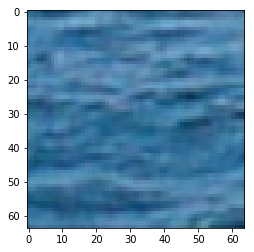

In [2]:
%load_ext autoreload
%autoreload 2

from ImageProcessing import ImageProcessing
from IterativeInpainting import IterativeInpainting
import numpy as np
import matplotlib.pyplot as plt

print()
print("Image originale")
ip = ImageProcessing()
image = ip.read_im('images/test_ocean.png')
ip.show_im(image)
plt.show()

Maintenant nous faisons varier le taille de point noir, le taille de patches (reglé par h) et nombre de patches (regle par h et step).

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


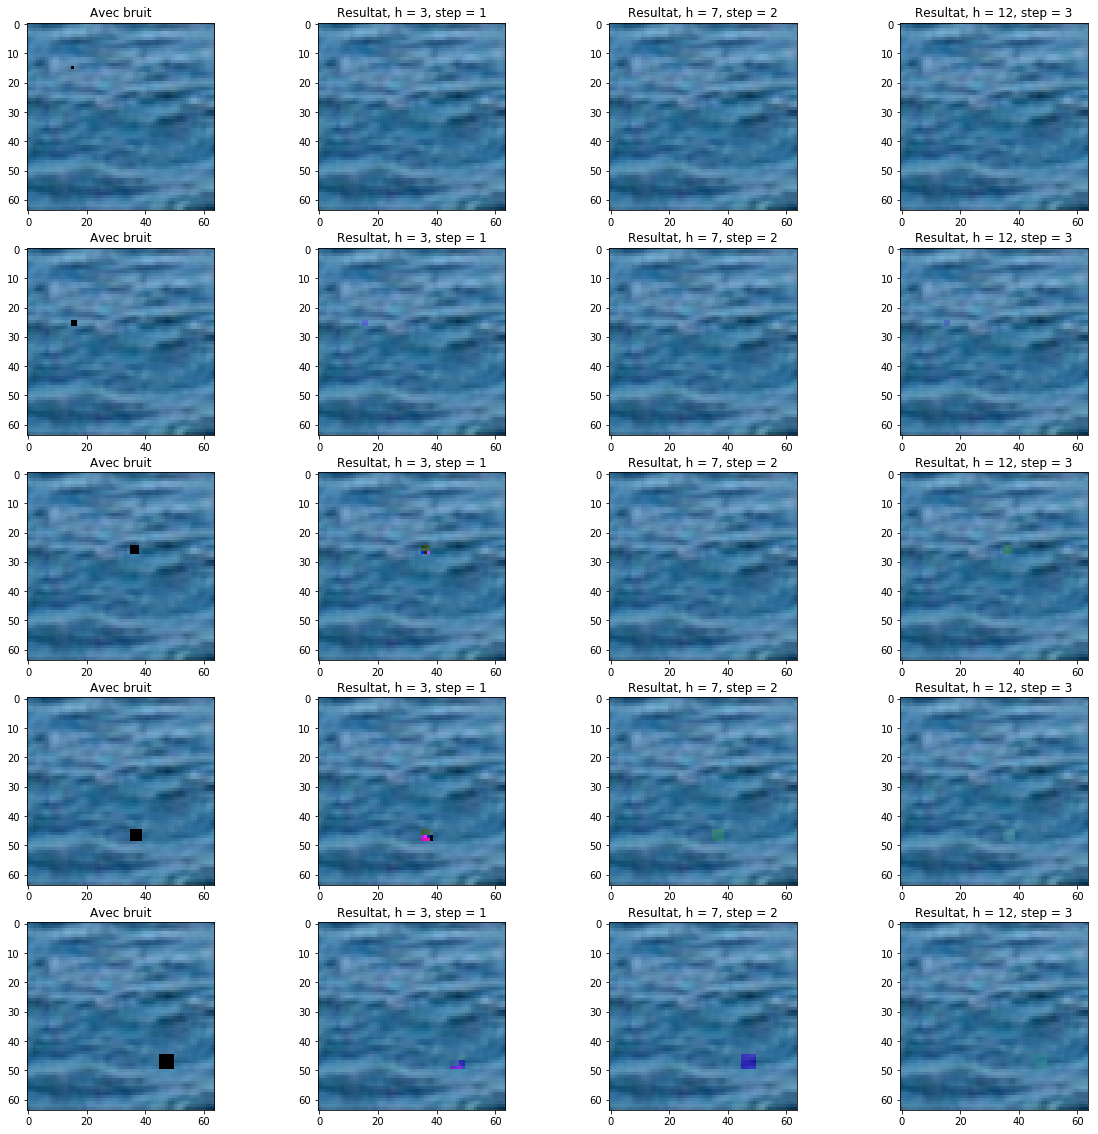

In [19]:
from tools import show_inpainting_images
points = [(15,15,1),(25,15,2),(25,35,3),(45,35,4),(45,45,5)]

h_options = [3,7,12]
step_options = [1,2,3]

alpha = 0.000001
images_orig = []
images_inp = {}
for i in range(len(h_options)):
    images_inp[i] = []

for x,y,size in points:
    noised_image = ip.delete_rect(image, x,y,size,size)
    images_orig.append(noised_image)

    for i in range(len(h_options)):
        h = h_options[i]
        step = step_options[i]
        inpainting = IterativeInpainting(noised_image, h=h, step_size=step)
        image_inpainted = inpainting.inpaint(alpha=alpha)
        images_inp[i].append((h,step,image_inpainted))

show_inpainting_images(ip, images_orig, images_inp, 4,5)

En general, plus grande le rectangle noir est, plus difficile c'est approximer le image original.

On peut aussi noter, que pour le bruit plus petit (ligne 2 et 3) les patches moyennes (colonne 3) semblent plus efficace que le patch grande (colonne 4).

### Plusieurs points du bruit
On repete la mémé experiment, mais en grandissent le proportion de bruit.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


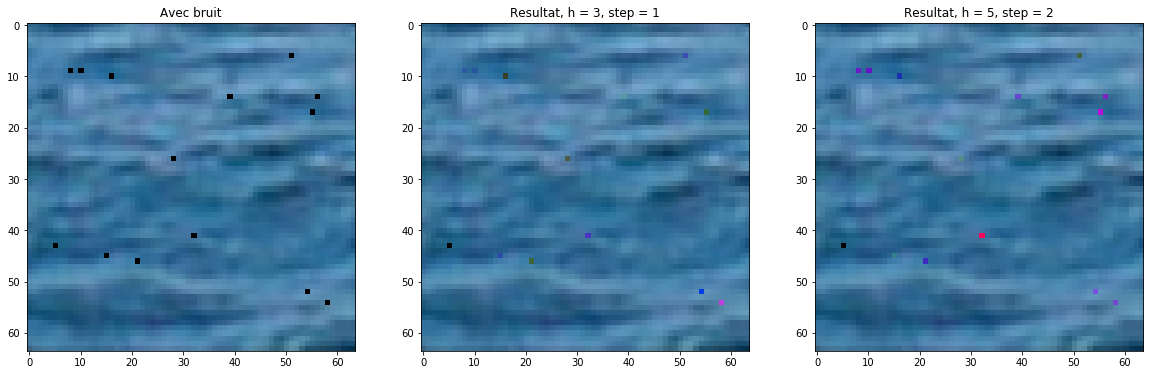

In [3]:
from tools import show_inpainting_images
bruit_quantite = [0.005]#,0.1]

h_options = [3,5]
step_options = [1,2]

#alpha = 0.000001
alpha = 0.0000001
images_orig = []
images_inp = {}
for i in range(len(h_options)):
    images_inp[i] = []

for bruit in bruit_quantite:
    noised_image = ip.noise(image, bruit, max(h_options))
    images_orig.append(noised_image)

    for i in range(len(h_options)):
        h = h_options[i]
        step = step_options[i]
        inpainting = IterativeInpainting(noised_image, h=h, step_size=step)
        image_inpainted = inpainting.inpaint(alpha=alpha)
        images_inp[i].append((h,step,image_inpainted))

show_inpainting_images(ip, images_orig, images_inp, len(h_options) + 1,len(bruit_quantite))